<a href="https://colab.research.google.com/github/JellePiepenbrock/neurosmash/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
from IPython.display import clear_output
import os, sys

drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/projects/entity_tagging/')

base_url = '/content//gdrive/My Drive/projects/NIPS/'

clear_output()

## VAE

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=32):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=512, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )

        model_parameters = filter(lambda p: p.requires_grad, self.encoder.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print('Trainable parameters encoder: ', params)
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, 32)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )

        model_parameters = filter(lambda p: p.requires_grad, self.decoder.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print('Trainable parameters decoder: ', params)
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar


# vae = VAE(image_channels=3).to(device)
# optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim import Adam
from PIL import Image
import torch.nn.functional as F
import numpy as np
import torch
from torch.autograd import Variable
from torch.distributions import Categorical
from random import randint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor

device = torch.device('cuda')
torch.manual_seed(42)
batch_size = 32

In [0]:
dataset = torch.load('{}/neurosmash/training_data.pt'.format(base_url))
dataset_flattened = np.array([np.transpose(x.data.numpy(), (1,2,0)) for x in dataset.reshape(-1, 3, 64, 64)])

In [0]:
backSub = cv2.createBackgroundSubtractorMOG2()
temp = np.uint8(dataset_flattened*255)[:10000]
    
for frame in temp:   
    frame = frame[0,:,:]
    fgMask = backSub.apply(frame)

filters = np.repeat(np.array([np.array(backSub.apply(np.uint8(x_*255))) for x_ in dataset_flattened]).reshape(-1, 1, 64, 64), 3, axis=1)
dataset_flattened = np.transpose(dataset_flattened, (0, 3, 1, 2))
dataset_flattened = np.array([np.array([x, f]) for x,f in zip(dataset_flattened, filters)])
dataset_flattened = torch.from_numpy(dataset_flattened).float() #/ 255
dataloader = torch.utils.data.DataLoader(dataset_flattened, batch_size=batch_size, shuffle=True)

Training new model with weights: 0
Trainable parameters encoder:  231200
Trainable parameters decoder:  43931
Loaded model.
Storing weights 10857.846371484375 9999999
Epoch 1, loss 339.3076991088867


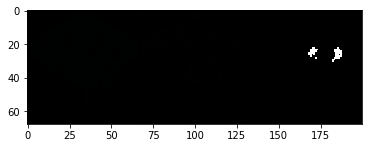

Storing weights 4587.991545703125 10857.846371484375
Epoch 2, loss 143.37473580322265
Storing weights 4578.132530078125 4587.991545703125
Epoch 3, loss 143.0666415649414
Storing weights 4575.337532421875 4578.132530078125
Epoch 4, loss 142.9792978881836


KeyboardInterrupt: ignored

In [8]:
# https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb <-- source for code. 
def loss_fn(recon_x, x, vae_weights, mu, logvar, use_weights):
    # Generate weights

    # Weighted BCE
    # vae_weights = torch.ones(1, 3, 64, 64).to(device)
    # vae_weights[:,0,:,:] *= 0.001
    # vae_weights *= 0.99
    # vae_weights = vae_weights.repeat(recon_x.shape[0], 1, 1, 1)
    if use_weights:
        BCE = F.binary_cross_entropy(recon_x, x, weight=vae_weights, reduction='sum')
    else:
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

def compare(x, f, vae):
    vae.eval()
    recon_x, _, _ = vae(x)
    vae.train()
    return torch.cat([x, recon_x, f])

def max_rgb_filter(image):
	(R, G, B) = cv2.split(image)
 
	# find the maximum pixel intensity values for each
	# (x, y)-coordinate,, then set all pixel values less
	# than M to zero
	M = np.maximum(np.maximum(R, G), B)
	R[R < M] = 0
	G[G < M] = 0
	B[B < M] = 0
 
	# merge the channels back together and return the image
	return cv2.merge([R, G, B])
 
def main(episodes):
    best_loss = 9999999
    epochs = 1000
    for use_weights in [0, 1]:
        print('===========================')
        print('Training new model with weights: {}'.format(use_weights))
        print('===========================')
        vae = VAE(image_channels=3).to(device)
        optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
        vae.train()
        print('Loaded model.')
        for epoch in range(epochs):
            losses = [] 
            batch_loss = 0
            
            for i, batch in enumerate(dataloader):
                optimizer.zero_grad()

                f = batch[:,1,:,:,:].squeeze().to(device)
                f[f > 0] = 5
                f[f == 0] = 0.5

                b = batch[:,0,:,:,:].squeeze().to(device)
                recon_images, mu, logvar = vae(b)
                
                loss, bce, kld = loss_fn(recon_images, b, f, mu, logvar, use_weights)
                loss.backward()
                optimizer.step()
                batch_loss += loss.item()

            batch_loss /= len(dataloader)
            if batch_loss < best_loss:
                print('Storing weights', batch_loss, best_loss)
                best_loss = batch_loss
                torch.save(vae.state_dict(), '{}/neurosmash/vae_v3_weights_{}.torch'.format(base_url, use_weights))

            if epoch == 200:
                print('reducing lr')
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-4
            elif epoch == 400:
                print('reducing lr')
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-5
            
            print('Epoch {}, loss {}'.format(epoch+1, batch_loss / batch_size))

            if epoch % 5 == 0:
                # Store model. 
                idx = randint(0, len(b)-1)           
                fixed_x = b[idx].unsqueeze(0)
                fixed_filter = batch[:,1,:,:,:].squeeze()[idx].unsqueeze(0)
                compare_x = compare(fixed_x.to(device), fixed_filter.to(device), vae)
                
                # print(torch.stack(, compare_x).shape)
                save_image(compare_x.data.cpu(), '{}/img_vae_{}/sample_image_epoch_{}.png'.format(base_url, use_weights, epoch))

                # Show final result. 
                img = mpimg.imread('{}/img_vae_{}/sample_image_epoch_{}.png'.format(base_url, use_weights, epoch))
                imgplot = plt.imshow(img.squeeze())
                plt.show()
main(50)

In [0]:
#TODO: Load model.

print('Encoding training data.')
#TODO Store all processed dps.
res = None
vae.eval()
for batch in dataset:
    batch = batch.to(device)
    z, mu, logvar = vae.encode(batch)
    z = z.unsqueeze(0)
    if res is None:
        res = z
    else:
        res = torch.cat((res, z))

## Beta VAE

In [0]:
"""model.py"""

import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable


def reparametrize(mu, logvar):
    std = logvar.div(2).exp()
    eps = Variable(std.data.new(std.size()).normal_())
    return mu + std*eps


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class BetaVAE_H(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017)."""

    def __init__(self, z_dim=10, nc=3):
        super(BetaVAE_H, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1),          # B,  32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32, 16, 16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),          # B,  64,  8,  8
            nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),          # B,  64,  4,  4
            nn.ReLU(True),
            nn.Conv2d(64, 256, 4, 1),            # B, 256,  1,  1
            nn.ReLU(True),
            View((-1, 256*1*1)),                 # B, 256
            nn.Linear(256, z_dim*2),             # B, z_dim*2
        )

        model_parameters = filter(lambda p: p.requires_grad, self.encoder.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print('Trainable parameters encoder: ', params)
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 64),               # B, 256
            View((-1, 64, 1, 1)),               # B, 256,  1,  1
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4),      # B,  64,  4,  4
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), # B,  64,  8,  8
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1), # B,  32, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 8, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(8, nc, 4, 2, 1),  # B, nc, 64, 64
        )

        model_parameters = filter(lambda p: p.requires_grad, self.decoder.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print('Trainable parameters encoder: ', params)

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        distributions = self._encode(x)
        mu = distributions[:, :self.z_dim]
        logvar = distributions[:, self.z_dim:]
        z = reparametrize(mu, logvar)
        x_recon = self._decode(z)

        return x_recon, mu, logvar

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)


def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim import Adam
from PIL import Image
import torch.nn.functional as F
import numpy as np
import torch
from torch.autograd import Variable
from torch.distributions import Categorical
from random import randint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, transform
import cv2

%matplotlib inline

from torchvision.utils import save_image
device = torch.device('cuda')

batch_size = 64

objective = 'H'
beta = 2
lr =  1e-4
z_dim =  32
max_iter =  1.5e6
decoder_dist = 'gaussian'

vae = BetaVAE_H(nc=3, z_dim=z_dim)
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr, betas=(0.9, 0.999))
print('Loaded model.')

# https://github.com/1Konny/Beta-VAE/blob/master/solver.py 

def mse_loss(input, target):
    return torch.sum((input - target) ** 2)

def weighted_mse_loss(input, target, weight):
    return torch.sum(weight * (input - target) ** 2)

def reconstruction_loss(x, x_recon, weights, distribution):
    batch_size = x.size(0)
    assert batch_size != 0

    if distribution == 'bernoulli':
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, size_average=False).div(batch_size)
    elif distribution == 'gaussian':
        # x_recon = F.sigmoid(x_recon)
        recon_loss = weighted_mse_loss(x_recon, x, weight=weights).sum() #F.mse_loss(x_recon, x, weights=weights, reduction='sum').div(batch_size)#, size_average=False).div(batch_size)
    else:
        recon_loss = None

    return recon_loss


def kl_divergence(mu, logvar):
    batch_size = mu.size(0)
    assert batch_size != 0
    if mu.data.ndimension() == 4:
        mu = mu.view(mu.size(0), mu.size(1))
    if logvar.data.ndimension() == 4:
        logvar = logvar.view(logvar.size(0), logvar.size(1))

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())
    total_kld = klds.sum(1).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = klds.mean(1).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld


def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

def max_rgb_filter(image):
	# split the image into its BGR components
	(R, G, B) = cv2.split(image)
 
	# find the maximum pixel intensity values for each
	# (x, y)-coordinate,, then set all pixel values less
	# than M to zero
	M = np.maximum(np.maximum(R, G), B)
	R[R < M] = 0
	G[G < M] = 0
	B[B < M] = 0
 
	# merge the channels back together and return the image
	return cv2.merge([R, G, B])
def main(episodes):
    dataset = None
    for i in range(1):
        if dataset is None:
            dataset = torch.load('{}/data/training_data_{}.pt'.format(base_url, i)) / 255
        else:
            dataset = torch.cat((dataset, torch.load('{}/data/training_data_{}.pt'.format(base_url, i)) / 255))
    
    test_dataset = torch.load('{}/data/training_data_{}.pt'.format(base_url, i+1)) / 255
    dataset = np.array([np.transpose(x.data.numpy(), (1,2,0)) for x in dataset])  

    if mode == 'ext':
        dataset = [max_rgb_filter(np.uint8(x*255)) for x in dataset]
        dataset = np.transpose(dataset, (0, 3, 1, 2))
        dataset[:,0,:,:] *= 0
    elif mode == 'canny':
        filters = [cv2.Canny(np.uint8(x_*255*255), 100, 200) for x_ in dataset]
        dataset = np.array([cv2.bitwise_and(x_, x_, mask=f) for x_, f in zip(dataset, filters)])
        dataset = np.transpose(dataset, (0, 3, 1, 2))
    elif mode == 'filter':
        filters = np.repeat(np.array([np.array(cv2.Canny(np.uint8(x_*255*255), 100, 200)) for x_ in dataset]).reshape(-1, 1, 64, 64), 3, axis=1)
        dataset = np.transpose(dataset, (0, 3, 1, 2))
        dataset = np.array([np.array([x, f]) for x,f in zip(dataset, filters)])

    dataset = torch.from_numpy(dataset).float() #/ 255

    # dataset = dataset[:100]
    # # Divide by 255
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    epochs = 125
    print(dataset.shape, test_dataset.shape)
    for epoch in range(epochs):
        losses = [] 
        for i, batch in enumerate(dataloader):
            optimizer.zero_grad()

            f = (batch[:,1,:,:,:].squeeze()).to(device)
            f[f == 0] = 0.05
            f[f == 255] = 10

            b = batch[:,0,:,:,:].squeeze().to(device)

            x_recon, mu, logvar = vae(b)
            recon_loss = reconstruction_loss(b, x_recon, f, decoder_dist)
            total_kld, dim_wise_kld, mean_kld = kl_divergence(mu, logvar)

            loss = recon_loss + beta*total_kld
            # elif objective == 'B':
            #     C = torch.clamp(self.C_max/self.C_stop_iter*self.global_iter, 0, self.C_max.data[0])
            #     beta_vae_loss = recon_loss + self.gamma*(total_kld-C).abs()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch == 100:
            print('reducing lr')
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-4
        print('Epoch {}, loss {}'.format(epoch+1, loss.item() / batch_size))
        if epoch % 5 == 0:
            fixed_x = b[randint(0, len(b)-1)].unsqueeze(0)
            compare_x = compare(fixed_x.to(device))
            
            # print(torch.stack(, compare_x).shape)
            save_image(compare_x.data.cpu(), '{}/neurosmash/images/sample_image_epoch_{}.png'.format(base_url, epoch))

            # Show final result. 
            img = mpimg.imread('{}/neurosmash/images/sample_image_epoch_{}.png'.format(base_url, epoch))
            imgplot = plt.imshow(img.squeeze())
            plt.show()
    
    print('Predicting test set:')
    for i, batch in enumerate(test_dataloader):
        if i > 10:
            break
        b = b.to(device)
        recon_images, mu, logvar = vae(b)

        fixed_x = b[randint(0, len(b)-1)].unsqueeze(0)
        compare_x = compare(fixed_x.to(device))
        
        save_image(compare_x.data.cpu(), '{}/neurosmash/images/sample_image_test_epoch_{}.png'.format(base_url, epoch))

        # Show final result. 
        img = mpimg.imread('{}/neurosmash/images/sample_image_test_epoch_{}.png'.format(base_url, epoch))
        imgplot = plt.imshow(img.squeeze())
        plt.show()

    # Store model. 
    torch.save(vae.state_dict(), 'b_vae.torch')
main(50)

## InfoVAE

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(3, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(32768, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, z_dim)
        ])
        
    def forward(self, x):
        #print("Encoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 32768),
            torch.nn.ReLU(),
            Reshape((128,16,16,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 3, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])
        
    def forward(self, x):
        #print("Decoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x

def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

class Model(torch.nn.Module):
    def __init__(self, z_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import math
import matplotlib.pyplot as plt


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

%matplotlib inline
z_dim = 4
vae = Model(z_dim).to(device)#VAE(image_channels=3).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
print('Loaded model.')

# https://github.com/napsternxg/pytorch-practice/blob/master/Pytorch%20-%20MMD%20VAE.ipynb
def compare(x):
    _, recon_x = vae(x)
    return torch.cat([x, recon_x])


def main(episodes):
    dataset = torch.load('{}/data/training_data_0.pt'.format(base_url)) #/ 255

    # Grayscale convertion.
    # dataset = [to_pil_image(x_) for x_ in dataset]
    # dataset = [to_grayscale(x_, 1) for x_ in dataset]
    # dataset = torch.stack([to_tensor(x_) for x_ in dataset])

    dataset = np.array([np.transpose(x.data.numpy(), (1,2,0)) for x in dataset])

    filters = [cv2.Canny(np.uint8(x_*255), 100, 200) for x_ in dataset]
    dataset = np.array([cv2.bitwise_and(x_, x_, mask=f) for x_, f in zip(dataset, filters)])
    dataset = np.transpose(dataset, (0, 3, 1, 2))


    # Divide by 255
    dataset = torch.from_numpy(dataset) / 255
    dataloader = torch.utils.data.DataLoader(dataset[:100], batch_size=batch_size, shuffle=True)
    epochs = 10000
    for epoch in range(epochs):
        losses = [] 
        for i, b in enumerate(dataloader):
            optimizer.zero_grad()
            x = b.to(device)
            z, x_reconstructed = vae(x) 

            true_samples = torch.randn(200, z_dim, requires_grad=False).to(device)
            mmd = compute_mmd(true_samples, z)
            nll = (x_reconstructed - x).pow(2).sum()
            loss = nll + mmd*2
            loss.backward()
            optimizer.step()
        if (epoch % 500 == 0) or (epoch == epochs-1):
            # Store one image per epoch to showcase development of VAE.
            print('Epoch {} loss {}'.format(epoch, loss.item()))
            fixed_x = dataset[1].unsqueeze(0)
            compare_x = compare(fixed_x.to(device))
            save_image(compare_x.data.cpu(), '{}/neurosmash/images_infovae/sample_image_epoch_{}.png'.format(base_url, epoch+1))

        print('Epoch {}, loss {}'.format(epoch+1, loss.item()))
    # Store model. 
    torch.save(vae.state_dict(), '{}/vae.torch'.format(base_url))

    # Show final result. 
    img = mpimg.imread('{}/neurosmash/images_infovae/sample_image_epoch_{}.png'.format(base_url, epochs))
    imgplot = plt.imshow(img)
    plt.show()

main(50)

## VAE-GAN <-- wtf is even happening here..

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy
from torchvision.utils import save_image
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim import Adam
from PIL import Image
import torch.nn.functional as F
import numpy as np
import torch
from torch.autograd import Variable
from torch.distributions import Categorical
from random import randint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, transform


# encoder block (used in encoder and discriminator)
class EncoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(EncoderBlock, self).__init__()
        # convolution to halve the dimensions
        self.conv = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=5, padding=2, stride=2,
                              bias=False)
        self.bn = nn.BatchNorm2d(num_features=channel_out, momentum=0.9)

    def forward(self, ten, out=False,t = False):
        # here we want to be able to take an intermediate output for reconstruction error
        if out:
            ten = self.conv(ten)
            ten_out = ten
            ten = self.bn(ten)
            ten = F.relu(ten, False)
            return ten, ten_out
        else:
            ten = self.conv(ten)
            ten = self.bn(ten)
            ten = F.relu(ten, True)
            return ten


# decoder block (used in the decoder)
class DecoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(DecoderBlock, self).__init__()
        # transpose convolution to double the dimensions
        self.conv = nn.ConvTranspose2d(channel_in, channel_out, kernel_size=5, padding=2, stride=2, output_padding=1,
                                       bias=False)
        self.bn = nn.BatchNorm2d(channel_out, momentum=0.9)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = self.bn(ten)
        ten = F.relu(ten, True)
        return ten


class Encoder(nn.Module):
    def __init__(self, channel_in=3, z_size=128):
        super(Encoder, self).__init__()
        self.size = channel_in
        layers_list = []
        # the first time 3->64, for every other double the channel size
        for i in range(3):
            if i == 0:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=64))
                self.size = 64
            else:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=self.size * 2))
                self.size *= 2

        # final shape Bx256x8x8
        self.conv = nn.Sequential(*layers_list)
        self.fc = nn.Sequential(nn.Linear(in_features=8 * 8 * self.size, out_features=1024, bias=False),
                                nn.BatchNorm1d(num_features=1024,momentum=0.9),
                                nn.ReLU(True))
        # two linear to get the mu vector and the diagonal of the log_variance
        self.l_mu = nn.Linear(in_features=1024, out_features=z_size)
        self.l_var = nn.Linear(in_features=1024, out_features=z_size)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = ten.view(len(ten), -1)
        ten = self.fc(ten)
        mu = self.l_mu(ten)
        logvar = self.l_var(ten)
        return mu, logvar

    def __call__(self, *args, **kwargs):
        return super(Encoder, self).__call__(*args, **kwargs)


class Decoder(nn.Module):
    def __init__(self, z_size, size):
        super(Decoder, self).__init__()
        # start from B*z_size
        self.fc = nn.Sequential(nn.Linear(in_features=z_size, out_features=8 * 8 * size, bias=False),
                                nn.BatchNorm1d(num_features=8 * 8 * size,momentum=0.9),
                                nn.ReLU(True))
        self.size = size
        layers_list = []
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size))
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//4))
        self.size = self.size//4
        # final conv to get 3 channels and tanh layer
        layers_list.append(nn.Sequential(
            nn.Conv2d(in_channels=self.size, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        ))

        self.conv = nn.Sequential(*layers_list)

    def forward(self, ten):

        ten = self.fc(ten)
        ten = ten.view(len(ten), -1, 8, 8)
        ten = self.conv(ten)
        return ten

    def __call__(self, *args, **kwargs):
        return super(Decoder, self).__call__(*args, **kwargs)


class Discriminator(nn.Module):
    def __init__(self, channel_in=3,recon_level=3):
        super(Discriminator, self).__init__()
        self.size = channel_in
        self.recon_levl = recon_level
        # module list because we need need to extract an intermediate output
        self.conv = nn.ModuleList()
        self.conv.append(nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True)))
        self.size = 32
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=128))
        self.size = 128
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        self.size = 256
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        # final fc to get the score (real or fake)
        self.fc = nn.Sequential(
            nn.Linear(in_features=8 * 8 * self.size, out_features=512, bias=False),
            nn.BatchNorm1d(num_features=512,momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=1),

        )

    def forward(self, ten,other_ten,mode='REC'):
        if mode == "REC":
            ten = torch.cat((ten, other_ten), 0)
            for i, lay in enumerate(self.conv):
                # we take the 9th layer as one of the outputs
                if i == self.recon_levl:
                    ten, layer_ten = lay(ten, True)
                    # we need the layer representations just for the original and reconstructed,
                    # flatten, because it's a convolutional shape
                    layer_ten = layer_ten.view(len(layer_ten), -1)
                    return layer_ten
                else:
                    ten = lay(ten)
        else:
            ten = torch.cat((ten, other_ten), 0)
            for i, lay in enumerate(self.conv):
                    ten = lay(ten)

            ten = ten.view(len(ten), -1)
            ten = self.fc(ten)
            return F.sigmoid(ten)


    def __call__(self, *args, **kwargs):
        return super(Discriminator, self).__call__(*args, **kwargs)


class VaeGan(nn.Module):
    def __init__(self,z_size=128,recon_level=3):
        super(VaeGan, self).__init__()
        # latent space size
        self.z_size = z_size
        self.encoder = Encoder(z_size=self.z_size)
        self.decoder = Decoder(z_size=self.z_size, size=self.encoder.size)
        self.discriminator = Discriminator(channel_in=3,recon_level=recon_level)
        # self-defined function to init the parameters
        self.init_parameters()

    def init_parameters(self):
        # just explore the network, find every weight and bias matrix and fill it
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                if hasattr(m, "weight") and m.weight is not None and m.weight.requires_grad:
                    #init as original implementation
                    scale = 1.0/numpy.sqrt(numpy.prod(m.weight.shape[1:]))
                    scale /=numpy.sqrt(3)
                    #nn.init.xavier_normal(m.weight,1)
                    #nn.init.constant(m.weight,0.005)
                    nn.init.uniform(m.weight,-scale,scale)
                if hasattr(m, "bias") and m.bias is not None and m.bias.requires_grad:
                    nn.init.constant(m.bias, 0.0)

    def forward(self, ten, gen_size=10):
        if self.training:
            # save the original images
            ten_original = ten
            # encode
            mus, log_variances = self.encoder(ten)
            # we need the true variances, not the log one
            variances = torch.exp(log_variances * 0.5)
            # sample from a gaussian

            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            # shift and scale using the means and variances

            ten = ten_from_normal * variances + mus
            # decode the tensor
            ten = self.decoder(ten)
            # discriminator for reconstruction
            ten_layer = self.discriminator(ten, ten_original, "REC")
            # decoder for samples

            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)

            ten = self.decoder(ten_from_normal)
            ten_class = self.discriminator(ten_original, ten, "GAN")
            return ten, ten_class, ten_layer, mus, log_variances
        else:
            if ten is None:
                # just sample and decode

                ten = Variable(torch.randn(gen_size, self.z_size).cuda(), requires_grad=False)
                ten = self.decoder(ten)
            else:
                mus, log_variances = self.encoder(ten)
                # we need the true variances, not the log one
                variances = torch.exp(log_variances * 0.5)
                # sample from a gaussian

                ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=False)
                # shift and scale using the means and variances
                ten = ten_from_normal * variances + mus
                # decode the tensor
                ten = self.decoder(ten)
            return ten



    def __call__(self, *args, **kwargs):
        return super(VaeGan, self).__call__(*args, **kwargs)

    @staticmethod
    def loss(ten_original, ten_predict, layer_original, layer_predicted, labels_original,
             labels_sampled, mus, variances):
        """
        :param ten_original: original images
        :param ten_predict:  predicted images (output of the decoder)
        :param layer_original:  intermediate layer for original (intermediate output of the discriminator)
        :param layer_predicted: intermediate layer for reconstructed (intermediate output of the discriminator)
        :param labels_original: labels for original (output of the discriminator)
        :param labels_predicted: labels for reconstructed (output of the discriminator)
        :param labels_sampled: labels for sampled from gaussian (0,1) (output of the discriminator)
        :param mus: tensor of means
        :param variances: tensor of diagonals of log_variances
        :return:
        """

        # reconstruction error, not used for the loss but useful to evaluate quality
        nle = 0.5*(ten_original.view(len(ten_original), -1) - ten_predict.view(len(ten_predict), -1)) ** 2
        # kl-divergence
        kl = -0.5 * torch.sum(-variances.exp() - torch.pow(mus,2) + variances + 1, 1)
        # mse between intermediate layers
        mse = torch.sum(0.5*(layer_original - layer_predicted) ** 2, 1)
        # bce for decoder and discriminator for original,sampled and reconstructed
        # the only excluded is the bce_gen_original

        bce_dis_original = -torch.log(labels_original + 1e-3)
        bce_dis_sampled = -torch.log(1 - labels_sampled + 1e-3)

        bce_gen_original = -torch.log(1-labels_original + 1e-3)
        bce_gen_sampled = -torch.log(labels_sampled + 1e-3)
        '''
        
        bce_gen_predicted = nn.BCEWithLogitsLoss(size_average=False)(labels_predicted,
                                         Variable(torch.ones_like(labels_predicted.data).cuda(), requires_grad=False))
        bce_gen_sampled = nn.BCEWithLogitsLoss(size_average=False)(labels_sampled,
                                       Variable(torch.ones_like(labels_sampled.data).cuda(), requires_grad=False))
        bce_dis_original = nn.BCEWithLogitsLoss(size_average=False)(labels_original,
                                        Variable(torch.ones_like(labels_original.data).cuda(), requires_grad=False))
        bce_dis_predicted = nn.BCEWithLogitsLoss(size_average=False)(labels_predicted,
                                         Variable(torch.zeros_like(labels_predicted.data).cuda(), requires_grad=False))
        bce_dis_sampled = nn.BCEWithLogitsLoss(size_average=False)(labels_sampled,
                                       Variable(torch.zeros_like(labels_sampled.data).cuda(), requires_grad=False))
        '''
        return nle, kl, mse, bce_dis_original, bce_dis_sampled,bce_gen_original,bce_gen_sampled

In [0]:
# just a class to store a rolling average
# useful to log to TB
class RollingMeasure(object):
    def __init__(self):
        self.measure = 0.0
        self.iter = 0

    def __call__(self, measure):
        # passo nuovo valore e ottengo average
        # se first call inizializzo
        if self.iter == 0:
            self.measure = measure
        else:
            self.measure = (1.0 / self.iter * measure) + (1 - 1.0 / self.iter) * self.measure
        self.iter += 1
        return self.measure

In [0]:
!pip install tensorboardX

In [0]:
import torch
import numpy
numpy.random.seed(8)
torch.manual_seed(8)
torch.cuda.manual_seed(8)
from torch.autograd import Variable
from torch.utils.data import Dataset
from tensorboardX import SummaryWriter
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
import progressbar
from torchvision.utils import make_grid


if __name__ == "__main__":

    train_folder = '{}/data/training_data_0.pt'.format(base_url)
    test_folder = '{}/data/training_data_1.pt'.format(base_url)
    z_size = 128#args.z_size
    recon_level = 3#args.recon_level
    decay_mse = 1#args.decay_mse
    decay_margin = 1#args.decay_margin
    n_epochs = 12#args.n_epochs
    lambda_mse = 1e-6#args.lambda_mse
    lr = 3e-4#args.lr
    decay_lr = 0.75#args.decay_lr
    decay_equilibrium = 1#args.decay_equilibrium
    slurm = False #args.slurm

    writer = SummaryWriter(comment="_CELEBA_NEW_DATA_STOCK_GAN")
    net = VaeGan(z_size=z_size,recon_level=recon_level).cuda()

    # train = torch.load(train_folder)

    # DATASET
    train = torch.load(train_folder)[:100]
    test = torch.load(test_folder)[:10]
    dataloader = torch.utils.data.DataLoader(train, batch_size=64,
                                                shuffle=True, num_workers=4)
    # DATASET for test
    # if you want to split train from test just move some files in another dir
    dataloader_test = torch.utils.data.DataLoader(test, batch_size=100,
                                                      shuffle=False, num_workers=1)

    #margin and equilibirum
    margin = 0.35
    equilibrium = 0.68
    #mse_lambda = 1.0
    # OPTIM-LOSS
    # an optimizer for each of the sub-networks, so we can selectively backprop
    #optimizer_encoder = Adam(params=net.encoder.parameters(),lr = lr,betas=(0.9,0.999))
    optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    #lr_encoder = MultiStepLR(optimizer_encoder,milestones=[2],gamma=1)
    lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr)
    #optimizer_decoder = Adam(params=net.decoder.parameters(),lr = lr,betas=(0.9,0.999))
    optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr)
    #lr_decoder = MultiStepLR(optimizer_decoder,milestones=[2],gamma=1)
    #optimizer_discriminator = Adam(params=net.discriminator.parameters(),lr = lr,betas=(0.9,0.999))
    optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr)
    #lr_discriminator = MultiStepLR(optimizer_discriminator,milestones=[2],gamma=1)

    batch_number = len(dataloader)
    step_index = 0
    widgets = [

        'Batch: ', progressbar.Counter(),
        '/', progressbar.FormatCustomText('%(total)s', {"total": batch_number}),
        ' ', progressbar.Bar(marker="-", left='[', right=']'),
        ' ', progressbar.ETA(),
        ' ',
        progressbar.DynamicMessage('loss_nle'),
        ' ',
        progressbar.DynamicMessage('loss_encoder'),
        ' ',
        progressbar.DynamicMessage('loss_decoder'),
        ' ',
        progressbar.DynamicMessage('loss_discriminator'),
        ' ',
        progressbar.DynamicMessage('loss_mse_layer'),
        ' ',
        progressbar.DynamicMessage('loss_kld'),
        ' ',
        progressbar.DynamicMessage("epoch")
    ]
    # for each epoch
    if slurm:
        print(args)
    for i in range(n_epochs):
        print(i)

        progress = progressbar.ProgressBar(min_value=0, max_value=batch_number, initial_value=0,
                                           widgets=widgets).start()
        # reset rolling average
        loss_nle_mean = RollingMeasure()
        loss_encoder_mean = RollingMeasure()
        loss_decoder_mean = RollingMeasure()
        loss_discriminator_mean = RollingMeasure()
        loss_reconstruction_layer_mean = RollingMeasure()
        loss_kld_mean = RollingMeasure()
        gan_gen_eq_mean = RollingMeasure()
        gan_dis_eq_mean = RollingMeasure()
        print("LR:{}".format(lr_encoder.get_lr()))

        # for each batch
        for j, data_batch in enumerate(dataloader):
            data_batch = data_batch / 255
            target_batch = data_batch
            
            # set to train mode
            net.train()
            # target and input are the same images

            data_target = Variable(target_batch, requires_grad=False).float().cuda()
            data_in = Variable(data_batch, requires_grad=False).float().cuda()


            # get output
            out, out_labels, out_layer, mus, variances = net(data_in)
            # split so we can get the different parts
            out_layer_predicted = out_layer[:len(out_layer) // 2]
            out_layer_original = out_layer[len(out_layer) // 2:]
            # TODO set a batch_len variable to get a clean code here
            out_labels_original = out_labels[:len(out_labels) // 2]
            out_labels_sampled = out_labels[-len(out_labels) // 2:]
            # loss, nothing special here
            nle_value, kl_value, mse_value, bce_dis_original_value, bce_dis_sampled_value,\
                bce_gen_original_value,bce_gen_sampled_value= VaeGan.loss(data_target, out, out_layer_original,
                                                                         out_layer_predicted, out_labels_original,
                                                                          out_labels_sampled, mus,
                                                                         variances)
            # THIS IS THE MOST IMPORTANT PART OF THE CODE
            loss_encoder = torch.sum(kl_value)+torch.sum(mse_value)
            loss_discriminator = torch.sum(bce_dis_original_value) + torch.sum(bce_dis_sampled_value)
            loss_decoder = torch.sum(lambda_mse * mse_value) - (1.0 - lambda_mse) * loss_discriminator
            # register mean values of the losses for logging
            loss_nle_mean(torch.mean(nle_value).data.cpu().numpy())
            loss_discriminator_mean((torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value)).data.cpu().numpy())
            loss_decoder_mean((torch.mean(lambda_mse * mse_value) - (1 - lambda_mse) * (torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value))).data.cpu().numpy())

            loss_encoder_mean((torch.mean(kl_value) + torch.mean(mse_value)).data.cpu().numpy())
            loss_reconstruction_layer_mean(torch.mean(mse_value).data.cpu().numpy())
            loss_kld_mean(torch.mean(kl_value).data.cpu().numpy())
            # selectively disable the decoder of the discriminator if they are unbalanced
            train_dis = True
            train_dec = True
            if torch.mean(bce_dis_original_value).item() < equilibrium-margin or torch.mean(bce_dis_sampled_value).item() < equilibrium-margin:
                train_dis = False
            if torch.mean(bce_dis_original_value).item() > equilibrium+margin or torch.mean(bce_dis_sampled_value).item() > equilibrium+margin:
                train_dec = False
            if train_dec is False and train_dis is False:
                train_dis = True
                train_dec = True

            #aggiungo log
            if train_dis:
                gan_dis_eq_mean(1.0)
            else:
                gan_dis_eq_mean(0.0)

            if train_dec:
                gan_gen_eq_mean(1.0)
            else:
                gan_gen_eq_mean(0.0)

            # BACKPROP
            # clean grads
            net.zero_grad()
            # encoder
            loss_encoder.backward(retain_graph=True)
            # someone likes to clamp the grad here
            #[p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
            # update parameters
            optimizer_encoder.step()
            # clean others, so they are not afflicted by encoder loss
            net.zero_grad()
            #decoder
            if train_dec:
                loss_decoder.backward(retain_graph=True)
                #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
                optimizer_decoder.step()
                #clean the discriminator
                net.discriminator.zero_grad()
            #discriminator
            if train_dis:
                loss_discriminator.backward()
                #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
                optimizer_discriminator.step()

            # LOGGING
            # if  slurm:
            # progress.update(progress.value + 1, loss_nle=loss_nle_mean.measure,
            #                 loss_encoder=loss_encoder_mean.measure,
            #                 loss_decoder=loss_decoder_mean.measure,
            #                 loss_discriminator=loss_discriminator_mean.measure,
            #                 loss_mse_layer=loss_reconstruction_layer_mean.measure,
            #                 loss_kld=loss_kld_mean.measure,
            #                 epoch=i + 1)

        # EPOCH END
        progress.update(progress.value + 1, loss_nle=loss_nle_mean.measure,
                        loss_encoder=loss_encoder_mean.measure,
                        loss_decoder=loss_decoder_mean.measure,
                        loss_discriminator=loss_discriminator_mean.measure,
                        loss_mse_layer=loss_reconstruction_layer_mean.measure,
                        loss_kld=loss_kld_mean.measure,
                        epoch=i + 1)
        lr_encoder.step()
        lr_decoder.step()
        lr_discriminator.step()
        margin *=decay_margin
        equilibrium *=decay_equilibrium
        #margin non puo essere piu alto di equilibrium
        if margin > equilibrium:
            equilibrium = margin
        lambda_mse *=decay_mse
        if lambda_mse > 1:
            lambda_mse=1
        progress.finish()

        writer.add_scalar('loss_encoder', loss_encoder_mean.measure, step_index)
        writer.add_scalar('loss_decoder', loss_decoder_mean.measure, step_index)
        writer.add_scalar('loss_discriminator', loss_discriminator_mean.measure, step_index)
        writer.add_scalar('loss_reconstruction', loss_nle_mean.measure, step_index)
        writer.add_scalar('loss_kld',loss_kld_mean.measure,step_index)
        writer.add_scalar('gan_gen',gan_gen_eq_mean.measure,step_index)
        writer.add_scalar('gan_dis',gan_dis_eq_mean.measure,step_index)

    for j, data_batch in enumerate(dataloader_test):
        data_batch = data_batch / 255
        target_batch = data_batch
        net.eval()

        data_in = Variable(data_batch, requires_grad=False).float().cuda()
        data_target = Variable(target_batch, requires_grad=False).float().cuda()
        out = net(data_in)
        out = out.data.cpu()
        out = (out + 1) / 2
        out = make_grid(out, nrow=8)
        save_image(out.data.cpu(), '{}/neurosmash/images_gan/sample_image_epoch_{}_rec.png'.format(base_url, j))

        img = mpimg.imread('{}/neurosmash/images_gan/sample_image_epoch_{}_rec.png'.format(base_url, j))
        imgplot = plt.imshow(img)
        plt.show()
        # out = net(None, 100)
        # out = out.data.cpu()
        # out = (out + 1) / 2
        # out = make_grid(out, nrow=8)
        # writer.add_image("generated", out, step_index)

        out = data_target.data.cpu()
        out = (out + 1) / 2
        out = make_grid(out, nrow=8)
        save_image(out.data.cpu(), '{}/neurosmash/images_gan/sample_image_epoch_{}_orig.png'.format(base_url, j))
        break

        step_index += 1

## PCA

In [0]:
%matplotlib inline
from sklearn.decomposition import PCA
import numpy as np 
import torch 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import time

X = np.transpose(torch.load('{}/data/training_data_0.pt'.format(base_url)).data.numpy(), (0, 2, 3, 1))
X = X[:,:,:, 0]
X = X.reshape(X.shape[0], -1)
# test = torch.load('{}/data/training_data_1.pt'.format(base_url)).data.numpy()
start = time.time()
pca = PCA(4, svd_solver='randomized').fit(X)
print(time.time() - start)
filename = '{}/PCA_model.pkl'.format(base_url)
pickle.dump(pca, open(filename, 'wb'))

# X_proj = pca.transform(X)

In [0]:
np.sum(pca.explained_variance_ratio_)

In [0]:
X_proj.shape

In [0]:
X_proj = pca.transform(X)
temp = pca.inverse_transform(X_proj)
temp = np.reshape(temp, (-1, 64, 64))
temp.shape

In [0]:
fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the faces, each image is 64 by 64 pixels 
for i in range(10): 
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(temp[i], cmap=plt.cm.bone, interpolation='nearest')

In [0]:
fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(10):
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[]) 
    ax.imshow(X[i].reshape(64, 64), cmap=plt.cm.bone, interpolation='nearest')